In [1]:
%load_ext autoreload
%autoreload 2

In [30]:

import torch
import torchvision
import re
import os
import random
import numpy
import glob
import matplotlib
import tifffile

from lightly.models.modules import heads
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot
from typing import Any
from skimage import filters
from scipy import stats

from dataset import TarFLCDataset
from modules.transforms import SimCLRTransform
from main import SimCLR
from backbones import get_backbone
from evaluation import get_dataset
from utils.plotting import savefig

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="nice-prism",
    colors=["#5F4690","#1D6996","#38A6A5","#0F8554","#73AF48","#EDAD08","#E17C05","#CC503E","#94346E"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="green-magenta",
    colors=["tab:green", "silver", "#ff00ff"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    name="factin",
    colors=["silver", "tab:purple"]
)
matplotlib.colormaps.register(cmap=cmap, force=True)
matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)


# Use a resnet backbone.
MODEL = "simclr-resnet18-STED"
MODEL = "IMAGENET1K_V1"
MODEL = "MICRA-Net"
# MODEL = "naive"
# MODEL = "U-Net"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
REQUIRES_3_CHANNELS = False
transform = None

if MODEL == "simclr-resnet18-STED":
    backbone, cfg = get_backbone("resnet18")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/resnet18/result.pt", map_location="cpu")

    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
elif MODEL == "MICRA-Net":
    backbone, cfg = get_backbone("micranet")
    model = SimCLR(backbone)
    
    checkpoint = torch.load("./data/ssl/baselines/micranet/result.pt", map_location="cpu")
    ckpt = checkpoint.get("model", None)
    if ckpt is not None:
        model.load_state_dict(ckpt)
    
elif MODEL == "IMAGENET1K_V1":
    transform = torchvision.models.ResNet18_Weights.IMAGENET1K_V1.transforms()
    backbone = torchvision.models.resnet18(weights="IMAGENET1K_V1")
    backbone.fc = torch.nn.Identity()
    model = SimCLR(backbone)
    REQUIRES_3_CHANNELS = True
elif MODEL == "naive": 
    backbone = get_backbone("naive")
    model = SimCLR(backbone)    
elif MODEL == "U-Net":
    backbone, _ = get_backbone("unet")
    checkpoint = "/home-local/Actin/pretrained-unet/"
    backbone.load_pretrained(checkpoint)
    
    model = SimCLR(backbone)
else:
    raise NotImplementedError
    
model = model.to(DEVICE)      
model.eval()
print(model)
print("Model loaded")

[%%%%] Loading pretrained model from: /home-local/Actin/pretrained-unet/
SimCLR(
  (backbone): UNet(
    (input_conv): DoubleConvolver(
      (conv): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (contracting_path): ModuleList(
      (0): Contracter(
        (conv): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConvolver(
            (conv): Sequential(
              (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stat

/tmp/ipykernel_3172227/901957340.py:31: UserWarning: Overwriting the cmap 'nice-prism' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_3172227/901957340.py:32: UserWarning: Overwriting the cmap 'nice-prism_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)
/tmp/ipykernel_3172227/901957340.py:38: UserWarning: Overwriting the cmap 'green-magenta' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_3172227/901957340.py:39: UserWarning: Overwriting the cmap 'green-magenta_r' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap.reversed(), force=True)
/tmp/ipykernel_3172227/901957340.py:45: UserWarning: Overwriting the cmap 'factin' that was already in the registry.
  matplotlib.colormaps.register(cmap=cmap, force=True)
/tmp/ipykernel_3172227/901957340.py:46: UserWarning: Overwriting the cmap 'factin_r' that wa

In [31]:
DATASET = "factin"
dataset = get_dataset(DATASET, transform=transform, requires_3_channels=REQUIRES_3_CHANNELS)
print(dataset)
# Build a PyTorch dataloader.
dataloader = torch.utils.data.DataLoader(
    dataset,  
    batch_size=32,
    shuffle=True,
    num_workers=0,
)

Block 86
0Mg 70
KCl 83
Glu-Gly 48
Dataset(F-actin) -- length: 7708
Block - 2482
0Mg - 1519
KCl - 2275
Glu-Gly - 1432



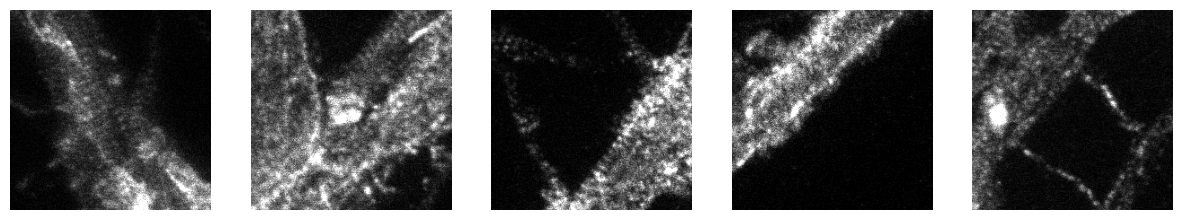

In [32]:
fig, axes = pyplot.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax = axes[i]
    random_idx = random.randint(0, len(dataset))
    img, info = dataset[random_idx]
    img = img.cpu().data.numpy()
    ax.imshow(img[0], vmin=numpy.quantile(img[0], 0.), vmax=numpy.quantile(img[0], 0.995), cmap="gray")
    ax.axis("off")
pyplot.show()

# Features

In [33]:
print(dataset)
out = defaultdict(list)
for x, info in tqdm(dataloader):
    x = x.to(DEVICE)
    try:
        features = model.backbone(x).flatten(start_dim=1)
    except IndexError:
        print(x.shape)
        print(model.backbone(x).shape)
        continue
    for key, values in info.items():
        if isinstance(values, torch.Tensor):
            out[key].extend(values.cpu().data.numpy().tolist())
        else:
            if len(values) != len(x):
                out[key].extend(numpy.array(values).T)
            else:
                out[key].extend(values)
    out["features"].extend(features.cpu().data.numpy())
    
    del x, features

Dataset(F-actin) -- length: 7708
Block - 2482
0Mg - 1519
KCl - 2275
Glu-Gly - 1432



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [00:24<00:00,  9.96it/s]


In [34]:
import phate 
samples = numpy.array(out["features"])
labels = numpy.array(out["label"])
indices = numpy.array(out["dataset-idx"])
if "path" in out:
    paths = numpy.array(out["path"])
    experiments = []
    for path in paths:
        experiments.append(path.split("EXP")[-1][:3])
    experiments = numpy.array(experiments)
    for unique in numpy.unique(experiments):
        mask = experiments == unique
        masked_samples = samples[mask]
        
#         masked_samples = masked_samples / numpy.linalg.norm(masked_samples, axis=1)[:, numpy.newaxis]
        masked_samples = (masked_samples - numpy.mean(masked_samples, axis=0)) / (numpy.std(masked_samples, axis=0) + 1e-6)
        samples[mask] = masked_samples
else:
    samples = samples / numpy.linalg.norm(samples, axis=1)[:, numpy.newaxis]
    # samples = (samples - numpy.mean(samples, axis=0)) / numpy.std(samples, axis=0)

phate_op = phate.PHATE(random_state=42, knn_dist="euclidean", mds_dist="euclidean")
X_transformed = phate_op.fit_transform(samples)

Calculating PHATE...
  Running PHATE on 7708 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.20 seconds.
    Calculating KNN search...
    Calculated KNN search in 5.44 seconds.
    Calculating affinities...
    Calculated affinities in 0.02 seconds.
  Calculated graph and diffusion operator in 5.69 seconds.
  Calculating landmark operator...
    Calculating SVD...


/opt/anaconda3/envs/ssl/lib/python3.10/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 274 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


    Calculated SVD in 0.40 seconds.
    Calculating KMeans...
    Calculated KMeans in 2.69 seconds.
  Calculated landmark operator in 3.73 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 1.96 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.61 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.30 seconds.
Calculated PHATE in 15.30 seconds.


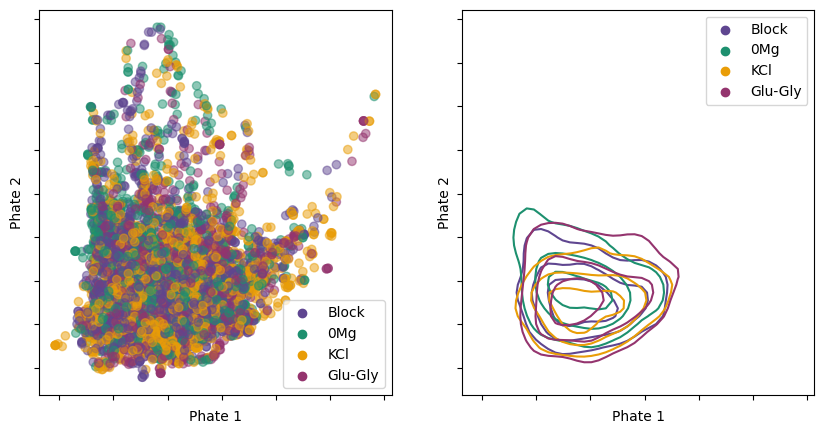

In [18]:
%matplotlib inline
fig, axes = pyplot.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
axes[0].scatter(*X_transformed.T, c=labels, cmap="nice-prism", alpha=0.5)
axes[0].set(
    xlabel="Phate 1", ylabel="Phate 2",
    xticklabels=[], yticklabels=[]
)
cmap = pyplot.get_cmap("nice-prism", len(numpy.unique(labels)))
axes[0].legend(
    handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(labels)],
    labels=dataset.classes
)
xmin, xmax = axes[0].get_xlim()
ymin, ymax = axes[1].get_ylim()

# fig, ax = pyplot.subplots(figsize=(5, 5))
X, Y = numpy.meshgrid(numpy.linspace(xmin, xmax), numpy.linspace(ymin, ymax))
positions = numpy.vstack([X.ravel(), Y.ravel()])
for unique in numpy.unique(labels):
    kernel = stats.gaussian_kde(X_transformed[labels == unique].T)
    Z = numpy.reshape(kernel(positions).T, X.shape)
    axes[1].contour(X, Y, Z, levels=3, colors=[cmap(unique)])
axes[1].set(
    xlim=(xmin, xmax), ylim=(ymin, ymax),
    xlabel="Phate 1", ylabel="Phate 2",
    xticklabels=[], yticklabels=[]    
)
axes[1].legend(
    handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(labels)],
    labels=dataset.classes
)
pyplot.show()

In [ ]:
%matplotlib notebook

import ipywidgets
from matplotlib import colors
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

fig, ax = pyplot.subplots(figsize=(10, 10))
ax.scatter(*X_transformed.T, c=labels, cmap="green-magenta", alpha=0.5, s=50)
ax.set(
    xlabel="Phate 1", ylabel="Phate 2",
    xticklabels=[], yticklabels=[]
)
cmap = pyplot.get_cmap("green-magenta", len(numpy.unique(labels)))
ax.legend(
    handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(labels)],
    labels=dataset.classes
)

# Creates the annotation box
norm = colors.Normalize(vmin=0, vmax=1)
if MODEL in ["IMAGENET1K_V1"]:
    norm = colors.Normalize(vmin=-1, vmax=1)
im = OffsetImage(dataset[0][0].numpy()[0], zoom=0.5, cmap="hot", norm=norm)
ab = AnnotationBbox(
    im, (0, 0), xybox=(75, 75), xycoords='data',
    boxcoords="offset points", frameon=False,
    arrowprops=dict(
        arrowstyle="-",
        connectionstyle="angle,angleA=0,angleB=90,rad=3")
)

# add it to the axes and make it invisible
ax.add_artist(ab)
ab.set_visible(False)

def hover(event):

    # Gets scatter points from ax
    sc = ax.collections[0]    

    contains, index = sc.contains(event)
    if contains:
        # May have multiple points in array
        index = index["ind"][0]
        # Sets the new position
        ab.xy = (X_transformed[index])

        sizes = numpy.ones(len(X_transformed)) * 50
        sizes[index] = 200
        sc.set_sizes(sizes)
        
        # Images are randomly shuffled, needs the index in dataset
        index = indices[index]
        im.set_data(dataset[index][0].numpy()[0])
        ab.set_visible(True)
    else:
        sizes = numpy.ones(len(X_transformed)) * 50
        sc.set_sizes(sizes)        

        ab.set_visible(False)
    fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('motion_notify_event', hover)
pyplot.show(block=True)

Calculating PHATE...
  Running PHATE on 287 observations and 128 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculating KNN search...
    Calculating affinities...
  Calculated graph and diffusion operator in 0.01 seconds.
  Calculating optimal t...
    Automatically selected t = 27
  Calculated optimal t in 0.02 seconds.
  Calculating diffusion potential...
  Calculating metric MDS...
  Calculated metric MDS in 0.04 seconds.
Calculated PHATE in 0.08 seconds.


/opt/anaconda3/envs/ssl/lib/python3.10/site-packages/graphtools/graphs.py:236: UserWarning: Metric cosine not valid for `sklearn.neighbors.BallTree`. Graph instantiation may be slower than normal.
  warnings.warn(


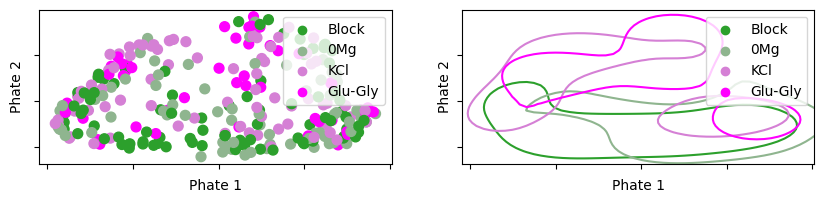

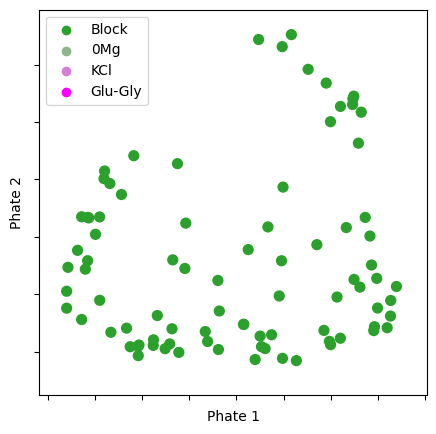

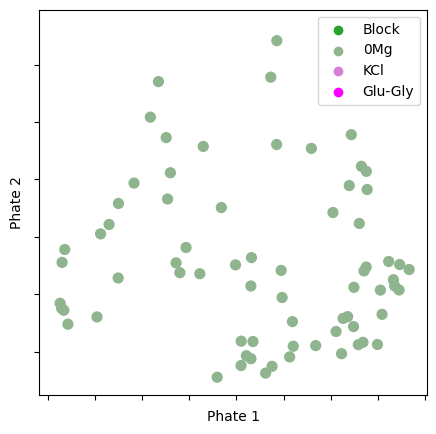

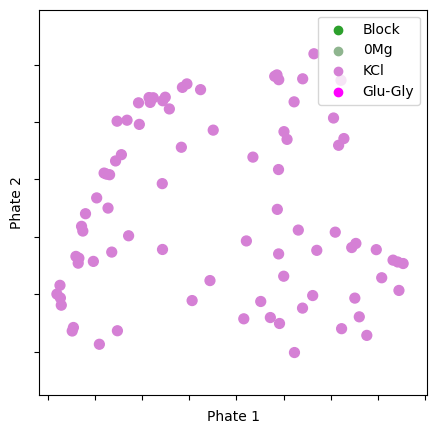

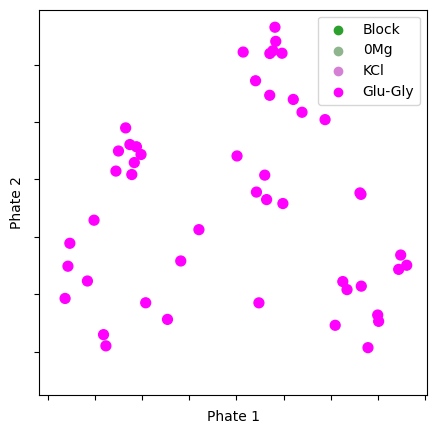

In [35]:
%matplotlib inline
SHOW_PER_EXP = False
SHOW_RATIOS = False
SHOW_PER_CLASS = True

def bootstrap(data, repetitions=10000):
    samples = numpy.random.choice(len(data), size=(repetitions, len(data)), replace=True)
    return numpy.median(data[samples], axis=1)

if "path" in out:
    paths = numpy.array(out["path"])
    if "ratios" in out:
        ratios = numpy.array(out["ratios"])
    else:
        ratios = numpy.ones(len(paths))

    per_path_samples, per_path_labels, per_path_ratios, experiments = [], [], [], []
    for unique in numpy.unique(paths):
        masked_features = samples[paths == unique]
        masked_labels = labels[paths == unique].tolist()
        masked_ratios = ratios[paths == unique]

        mean = numpy.mean(masked_features, axis=0)
        std = numpy.std(masked_features, axis=0)
#         per_path_samples.append(numpy.concatenate((mean, std)))
        per_path_samples.append(mean)        
        per_path_labels.append(max(masked_labels, key=masked_labels.count))
        per_path_ratios.append(numpy.mean(masked_ratios, axis=0))
        experiments.append(unique.split("EXP")[-1][:3])

    per_path_samples = numpy.array(per_path_samples)
    per_path_labels = numpy.array(per_path_labels)
    per_path_ratios = numpy.array(per_path_ratios)    

#     per_path_samples = (per_path_samples - numpy.mean(per_path_samples, axis=0)) / numpy.std(per_path_samples, axis=0)
    
    phate_op = phate.PHATE(random_state=42, knn_dist="cosine", mds_dist="cosine")
    X_transformed = phate_op.fit_transform(per_path_samples)

    CMAP_NAME = "green-magenta"
    fig, axes = pyplot.subplots(1, 2, figsize=(10, 2), sharey=True, sharex=True)
    axes[0].scatter(*X_transformed.T, c=per_path_labels, cmap=CMAP_NAME, alpha=1.0, s=50)
    axes[0].set(
        xlabel="Phate 1", ylabel="Phate 2",
        xticklabels=[], yticklabels=[]
    )
    cmap = pyplot.get_cmap(CMAP_NAME, len(numpy.unique(labels)))
    axes[0].legend(
        handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(labels)],
        labels=dataset.classes
    )
    xmin, xmax = axes[0].get_xlim()
    ymin, ymax = axes[1].get_ylim()

    # fig, ax = pyplot.subplots(figsize=(5, 5))
    X, Y = numpy.meshgrid(numpy.linspace(xmin, xmax, 50), numpy.linspace(ymin, ymax, 50))
    positions = numpy.vstack([X.ravel(), Y.ravel()])
    for unique in numpy.unique(labels):
#         bootstraped = bootstrap(X_transformed[per_path_labels == unique])
#         kernel = stats.gaussian_kde(bootstraped.T)

        kernel = stats.gaussian_kde(X_transformed[per_path_labels == unique].T)    
    
        Z = numpy.reshape(kernel(positions).T, X.shape)
#         Z[Z<numpy.quantile(Z, 0.5)] = numpy.quantile(Z, 0.5)
        
        axes[1].contour(X, Y, Z, levels=[numpy.quantile(Z, 0.75)], colors=[cmap(unique)])
    axes[1].set(
#         xlim=(xmin, xmax), ylim=(ymin, ymax),
        xlabel="Phate 1", ylabel="Phate 2",
        xticklabels=[], yticklabels=[]    
    )
    axes[1].legend(
        handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(per_path_labels)],
        labels=dataset.classes
    )
    savefig(fig, axes, f"./panels/features/{MODEL}", save_white=True)
    pyplot.show()    
    
    if SHOW_RATIOS:
        fig, axes = pyplot.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
        axes[0].scatter(*X_transformed.T, c=per_path_ratios[:, 0], cmap="RdPu", alpha=1.0, vmin=0.0, vmax=1.0, edgecolor="black")
        axes[1].scatter(*X_transformed.T, c=per_path_ratios[:, 1], cmap="RdPu", alpha=1.0, vmin=0.0, vmax=1.0, edgecolor="black")        
        
        for ax in axes.ravel():
            ax.set(
        #         xlim=(xmin, xmax), ylim=(ymin, ymax),
                xlabel="Phate 1", ylabel="Phate 2",
                xticklabels=[], yticklabels=[]    
            )
#             pyplot.colorbar(sc, ax=ax)
        pyplot.show()
    if SHOW_PER_EXP:
        uniques = numpy.unique(experiments).tolist()
        for unique in uniques:
            mask = [unique == exp for exp in experiments]
            fig, ax = pyplot.subplots(figsize=(5, 5))
            ax.scatter(*X_transformed[mask].T, c=per_path_labels[mask], cmap=CMAP_NAME, alpha=1.0, vmin=0, vmax=max(labels))
            ax.set(
                xlim=(xmin, xmax), ylim=(ymin, ymax), 
                xlabel="Phate 1", ylabel="Phate 2",
                xticklabels=[], yticklabels=[],
                title=f"EXP{unique}"
            )
            cmap = pyplot.get_cmap(CMAP_NAME, len(numpy.unique(labels)))
            ax.legend(
                handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(labels)],
                labels=dataset.classes
            )
            pyplot.show()        
    if SHOW_PER_CLASS:
        for unique in numpy.unique(labels):
            fig, ax = pyplot.subplots(figsize=(5, 5), sharey=True, sharex=True)
            ax.scatter(*X_transformed[per_path_labels == unique].T, c=per_path_labels[per_path_labels == unique], cmap=CMAP_NAME, alpha=1.0, s=50, vmin=numpy.min(per_path_labels), vmax=numpy.max(per_path_labels))
            ax.set(
                xlim=(xmin, xmax), ylim=(ymin, ymax),                 
                xlabel="Phate 1", ylabel="Phate 2",
                xticklabels=[], yticklabels=[]
            )
            cmap = pyplot.get_cmap(CMAP_NAME, len(numpy.unique(labels)))
            ax.legend(
                handles=[pyplot.scatter(None, None, color=cmap(unique)) for unique in numpy.unique(labels)],
                labels=dataset.classes
            )
#             savefig(fig, axes, f"./panels/features/{MODEL}-{dataset.classes[unique]}", save_white=True)
            pyplot.show()